# Generative Models (160 + 40 points)

## Diffusion Models vs. GANs vs. VAE

### HW4 @ DL Course, Dr. Soleymani, Spring 2023

*Full Name:* MohammadHossein Sameti

*SID:* 401204932

In this notebook, we are going to implement Variational AutoEncoder (VAE), Denoising Diffusion Probabilistic Model (DDPM) and Generative Adversarial Network (GAN) on the FashionMNIST dataset. To generate images, these models convert noise to images from the training distribution, but the key difference is that Diffusion models denoise the image gradually. The following sections briefly describe each model.

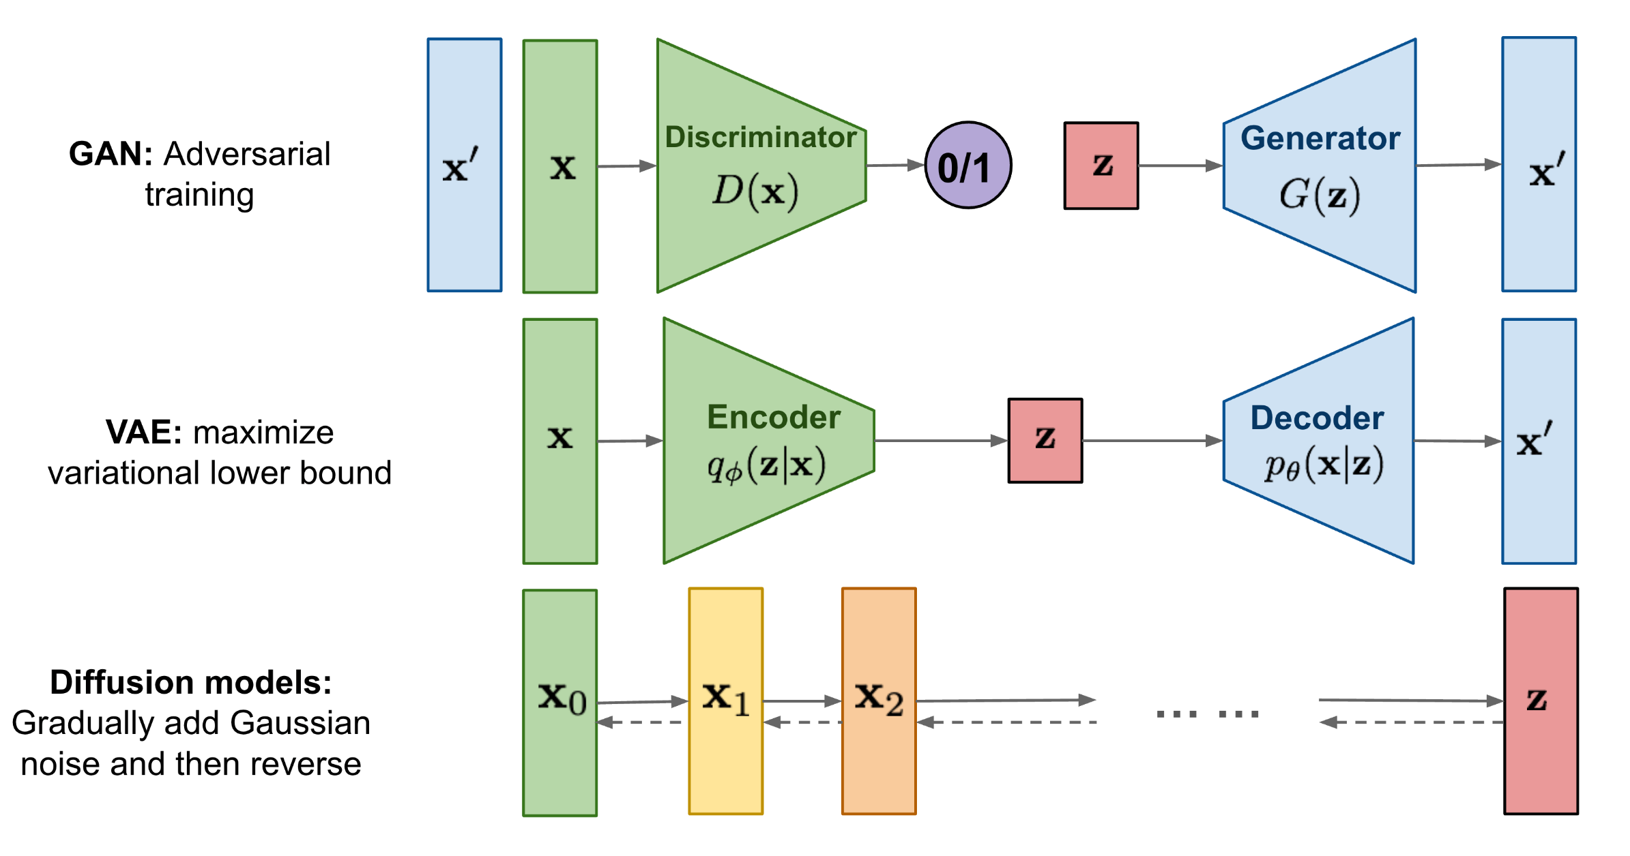

**NOTICE:** 
+ Please complete the code in the given structure. You may change the hyperparameters according to your computing power as long as the results indicate the desired performance.
+ Complete the `TODO` parts in the code accordingly. 
+ Remember to answer the conceptual questions. 

## Dataset

We are going to work on the FashionMNIST dataset. FashionMNIST consists of a training set of 60,000 examples and a test set of 10,000 samples. Each sample is a 28x28 grayscale image associated with a label from 10 classes. We are going to use the training split in this notebook. You can use `dataloader` to train your models. Also, you can use `plot_samples` to plot a sequence of images (e.g. iteratively denoised images by DDPM).

In [6]:
from torchvision import transforms 
from torch.utils.data import DataLoader
from torch import optim
from tqdm.notebook import tqdm
from torch.autograd import Variable 

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

BATCH_SIZE = 8
IMG_SIZE = 32 
C_IN = 1 # Number of input channels
LR = 1e-3
EPOCHS = 40

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

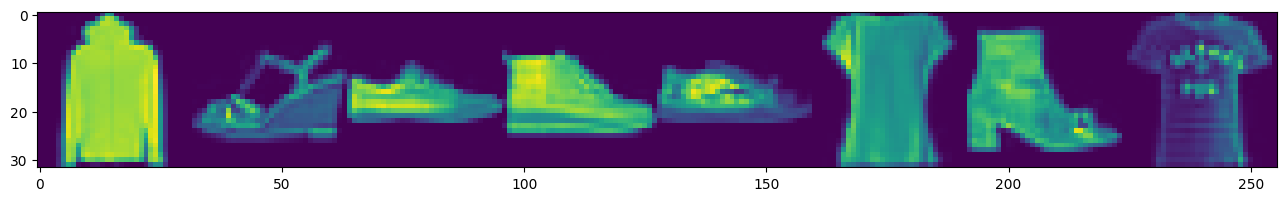

In [7]:
def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  
        transforms.Lambda(lambda t: (t * 2) - 1) 
    ]

    data_transform = transforms.Compose(data_transforms)

    data = torchvision.datasets.FashionMNIST(root=".", download=True, 
                                         train=True, transform=data_transform)
    return data


def plot_images(images):
    plt.figure(figsize=(16, 3))
    plt.imshow(torch.cat([
        torch.cat([i for i in images], dim=-1)
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()


data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, 
                        shuffle=True, drop_last=True)
batch_x, batch_y = next(iter(dataloader))
plot_images(batch_x[:8])

## GAN (39 + 15 points)

GAN's architecture consists of a Discriminator and a Generator. The Discriminator identifies whether an input image ($x$) is real or generated by the Generator. The Generator tries to create fake images given a random noise ($z$) such that the Discriminator can not distinguish them from the real images. These functionalities give rise to an adversarial situation where these networks can be seen as players. Thus, the standard loss for GAN is the following min-max loss. The Generator tries to minimize it, while the Discriminator tries to maximize it.

$$ \min_{\theta_g} \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

We try to optimize this loss function by alternating between the following objectives for the Discriminator and the Generator:
+ Discriminator's objective:
 $$ \max_{\theta_d} E_{x \sim p_{data}}[log(D_{\theta_d}(x)] + E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$
+ Generator's objective:
$$ \min_{\theta_g} E_{z \sim p(z)}[log(1 - D_{\theta_d}(G_{\theta_g}(z)))] $$

Each player’s cost depends on the parameters of the other player. However, each
player can only optimize its own parameters.

### ❓ **Question 2**
*(8 points)*
> What are the challenges in this optimization process? How do they address each of these challenges?

شبکه گن شامل دو بخش جنریتور و دسکریمینتور میباشد که هر بخش سعی در کم کردن ضرر خود است که باعث افزایش ضرر دیگری میشود. رسیدن به یک نقطه زینی یک چالش است. برای رسیدن به این هدف در هر مرحله یکی در میان (یا چند درمیان) میتوان یک شبکه را ثابت در نظر گرفت و شبکه دیگر را آموزش داد تا به تعادل رسید.

از چالش های شبکه های گن میتوان به موارد زیر هم اشاره کرد:
۱-تولید تصاویر با تنوع پایین، برای رفع این مشکل میتوان از مینی بچ استفاده کرد. 
۲- در صورتی که شبکه دسکریمنیتور بسیار خوب عمل کند شبکه جنریتور نمیتواند خوب اموزش ببیند برای حل این مشکل میتوان از تابع هزینه های دیگری مانند هینج لاس استفاده کرد. 
۳- شبکه های گن به انتخاب هابپر پارامتر بسیار حساس اند، برای رفع این مشکل میتوان از تکنیک های سرچ استفاده کرد.

In [8]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Generator, self).__init__()

        ##########################################################
        # TODO (2 points): 
        # Define the generator model here. You may use linear layers, 
        # normalization layers, and activation layers.  
        ##########################################################

        self.generator = nn.Sequential(
            # in 256*1*1
            nn.ConvTranspose2d(256, 16*16, kernel_size=4, stride=1, padding=0, device=DEVICE),
            nn.BatchNorm2d(16*16, device=DEVICE),
            nn.ReLU(),  
            # in 256*4*4  
            nn.ConvTranspose2d(16*16, 16*8, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*8, device=DEVICE),
            nn.ReLU(),
            # in 128*8*8  
            nn.ConvTranspose2d(16*8, 16*4, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*4, device=DEVICE),
            nn.ReLU(),
            # in 64*16*16
            nn.ConvTranspose2d(16*4, 1, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.Tanh()
            # out 1*32*32
            )

    def forward(self, z): 

        #img = None

        ##########################################################
        # TODO (2 points): 
        # Generate images from the random noise `z`.
        ##########################################################
        img = self.generator(z)

        return img

class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Discriminator, self).__init__()
        
        ##########################################################
        # TODO (2 points): 
        # Define the Discriminator model here. You may use linear 
        # layers, normalization layers, and activation layers.  
        ##########################################################
        self.descriminator = nn.Sequential(
            # in 1*32*32
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.LeakyReLU(0.2),
            # in 16*16*16
            nn.Conv2d(16, 16*2, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*2, device=DEVICE),
            nn.LeakyReLU(0,2),
            # in 32*8*8
            nn.Conv2d(16*2, 16*4, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*4, device=DEVICE),
            nn.LeakyReLU(0,2),
            # in 64*4*4
            nn.Conv2d(16*4, 1, kernel_size=4, stride=2, padding=0, device=DEVICE),
            nn.Sigmoid()
            # out 1*1
            )
        
    
    def forward(self, img):

        ##########################################################
        # TODO (2 points): 
        # Predict whether each image in `img` is real or fake.
        ##########################################################
        real_or_fake = self.descriminator(img)

        return real_or_fake

class GANManager():
    def __init__(self, *args, **kwargs):
        
        ##########################################################
        # TODO (3 points): 
        # 1) Instantiate the Generator and the Discriminator.
        # 2) Define your optimizer(s). You can use Adam.
        ##########################################################

        self.generator = Generator()
        self.discriminator = Discriminator()
        self.opt_d = optim.Adam(self.discriminator.parameters(), lr=LR)
        self.opt_g = optim.Adam(self.generator.parameters(), lr=LR)

    def train(self, dataloader, **kwargs):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(EPOCHS):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)

                ##########################################################
                # TODO (15 points): 
                # Calculate the loss for the Generator and the Discriminator.
                # Perform the optimization on `batch_x`.
                ##########################################################
                self.opt_d.zero_grad()
                labels = (torch.ones(8)*0.9).to(DEVICE)
                out = self.discriminator(batch_x).reshape(-1) 
                loss_d_real = nn.BCELoss()(out, labels)
                noise = torch.randn(8, 256, 1, 1).to(DEVICE)
                fake_imgs = self.generator(noise)
                labels = (torch.ones(8)*0.1).to(DEVICE)
                out = self.discriminator(fake_imgs.detach()).reshape(-1)
                loss_d_fake = nn.BCELoss()(out, labels)

                discriminator_loss = loss_d_real + loss_d_fake
                discriminator_loss.backward()
                self.opt_d.step()

                

                self.opt_g.zero_grad()
                labels = torch.ones(8).to(DEVICE)
                out = self.discriminator(fake_imgs).reshape(-1)
                generator_loss = nn.BCELoss()(out, labels)
                generator_loss.backward()
                self.opt_g.step()

                #generator_loss = None
                #discriminator_loss = None
                
                total_g_loss.append(generator_loss.item())
                total_d_loss.append(discriminator_loss.item())


            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, EPOCHS, mean_d_loss, mean_g_loss)
            )
            
            self.sample(8, plot=True)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, plot=True):

        ##########################################################
        # TODO (1 points): 
        # First, assign proper Gaussian noises to `z`.
        # Then, use can see that by using the Generator, we can
        # make new images and plot them.
        ##########################################################

        z = torch.randn(n, 256, 1, 1).to(DEVICE)
        with torch.no_grad():
            gen_imgs = self.generator(z).to('cpu')
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 1/40] [D loss: 0.8912] [G loss: 1.8958]


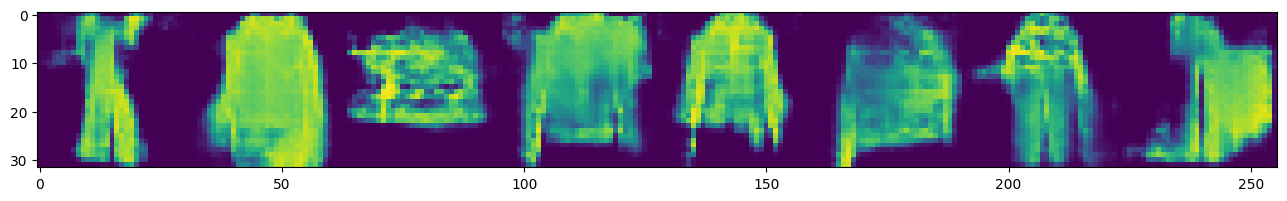

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 2/40] [D loss: 0.8282] [G loss: 2.0597]


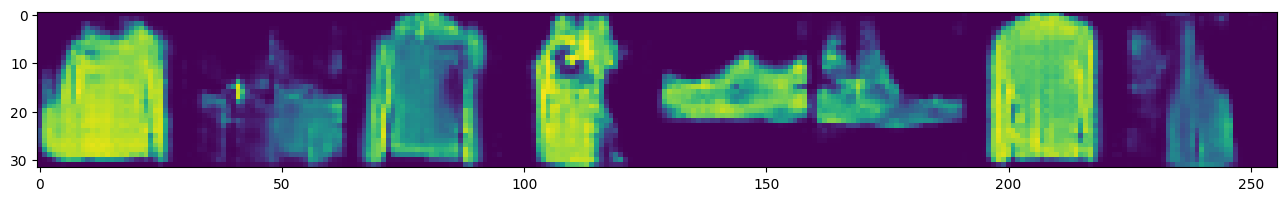

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 3/40] [D loss: 0.7914] [G loss: 2.1513]


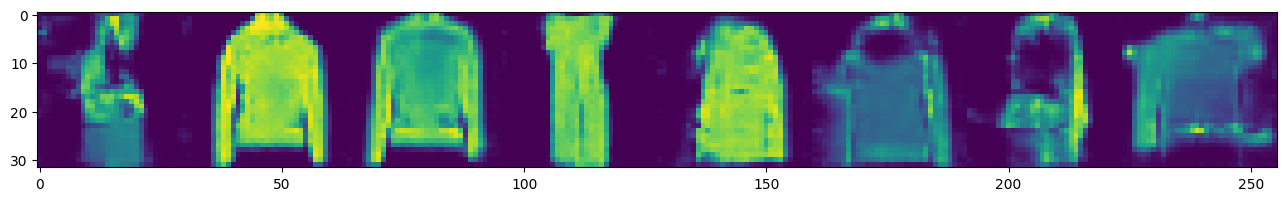

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 4/40] [D loss: 0.7643] [G loss: 2.2021]


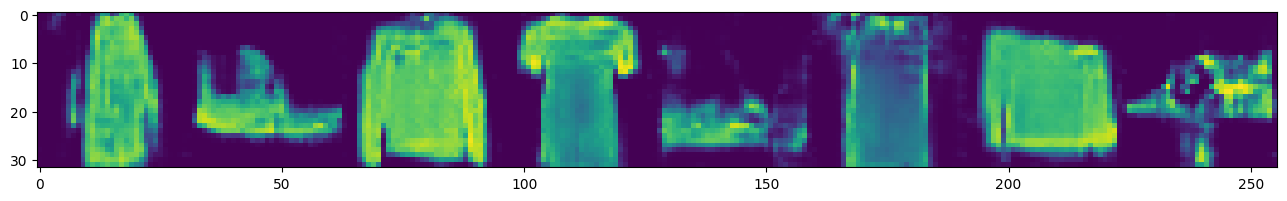

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 5/40] [D loss: 0.7502] [G loss: 2.2229]


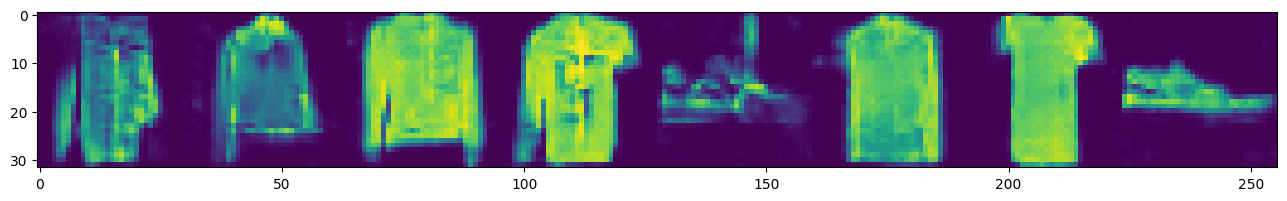

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 6/40] [D loss: 0.7408] [G loss: 2.2307]


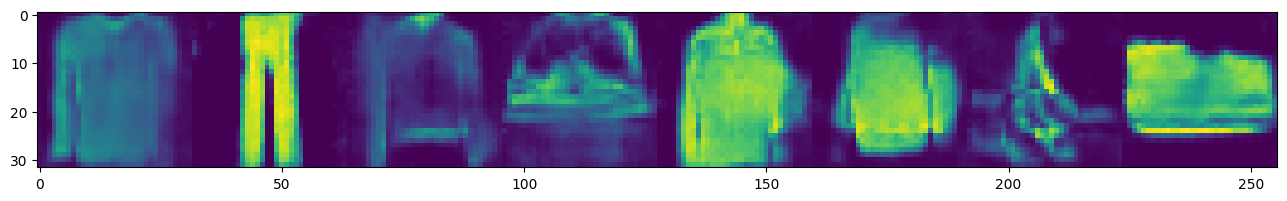

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 7/40] [D loss: 0.7304] [G loss: 2.2458]


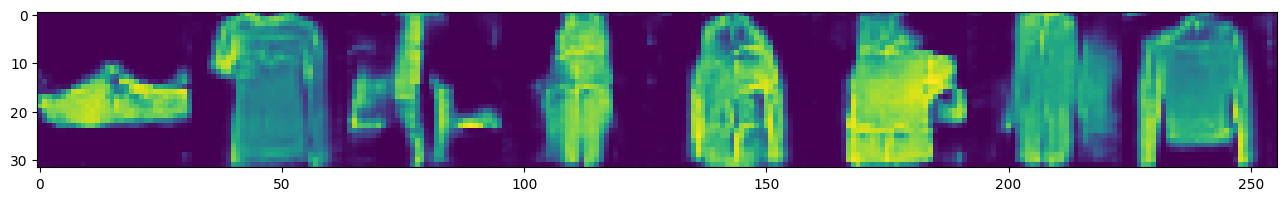

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 8/40] [D loss: 0.7229] [G loss: 2.2589]


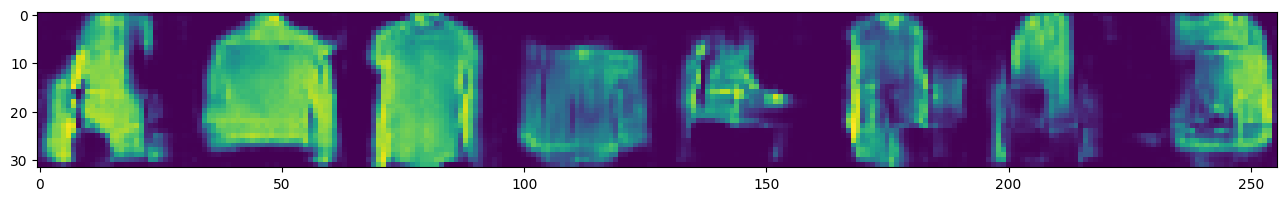

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 9/40] [D loss: 0.7234] [G loss: 2.2577]


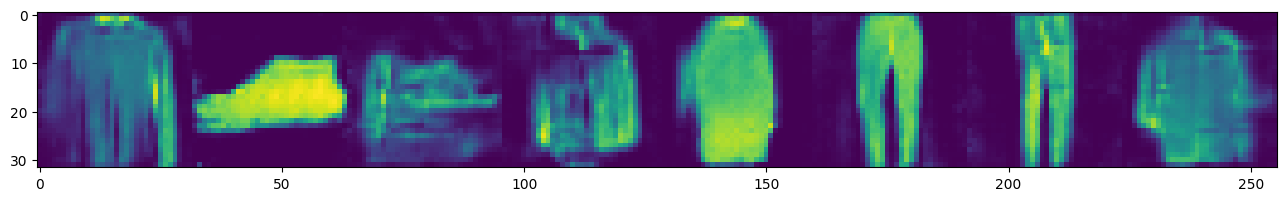

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 10/40] [D loss: 0.7156] [G loss: 2.2646]


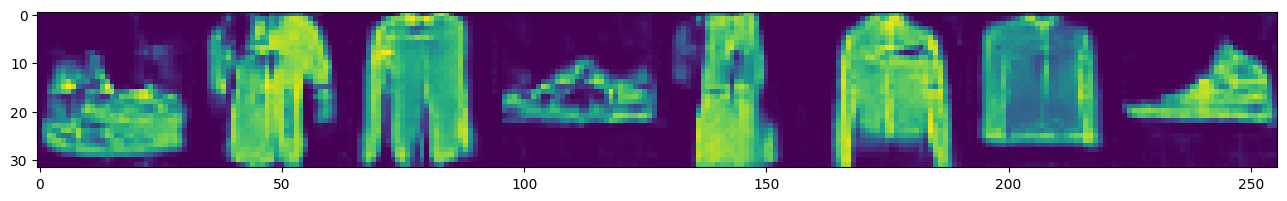

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 11/40] [D loss: 0.7130] [G loss: 2.2738]


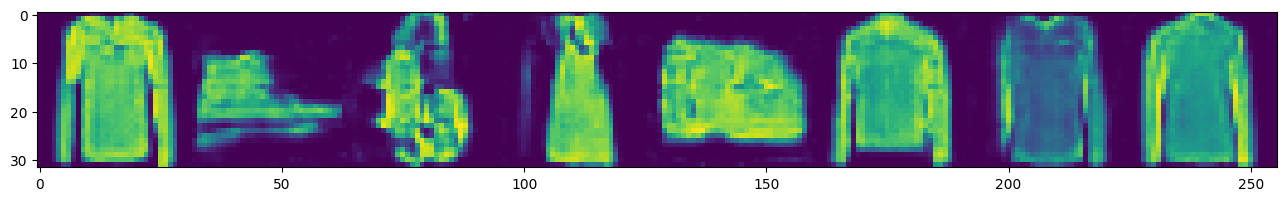

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 12/40] [D loss: 0.7121] [G loss: 2.2645]


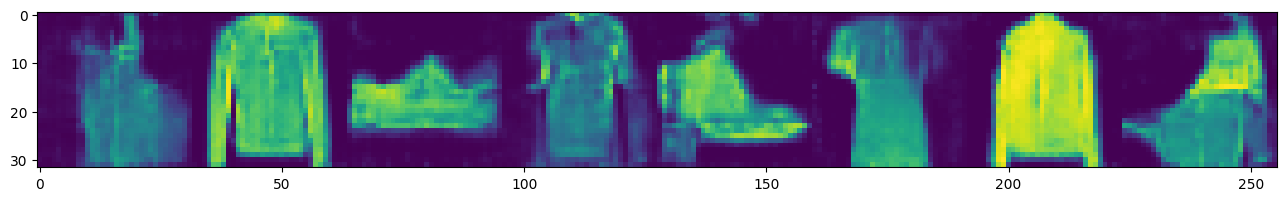

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 13/40] [D loss: 0.7087] [G loss: 2.2722]


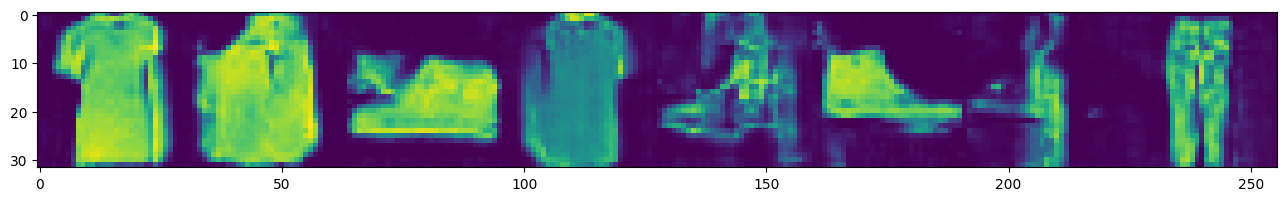

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 14/40] [D loss: 0.7069] [G loss: 2.2769]


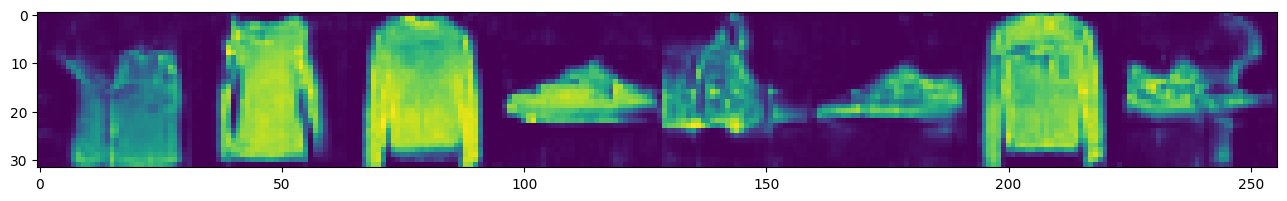

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 15/40] [D loss: 0.7062] [G loss: 2.2755]


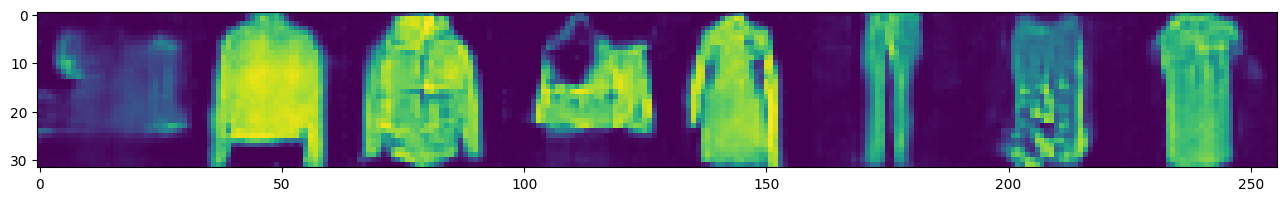

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 16/40] [D loss: 0.7032] [G loss: 2.2838]


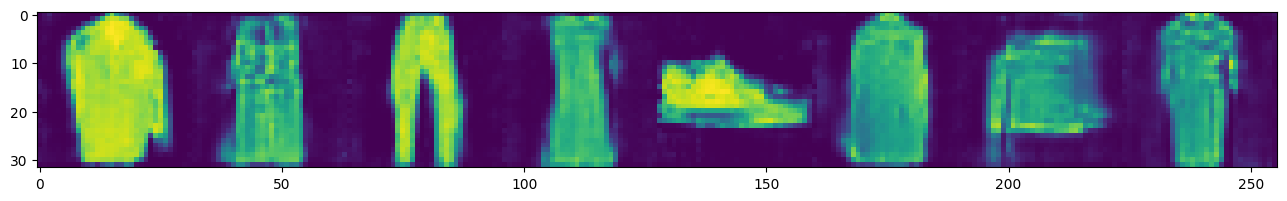

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 17/40] [D loss: 0.7019] [G loss: 2.2826]


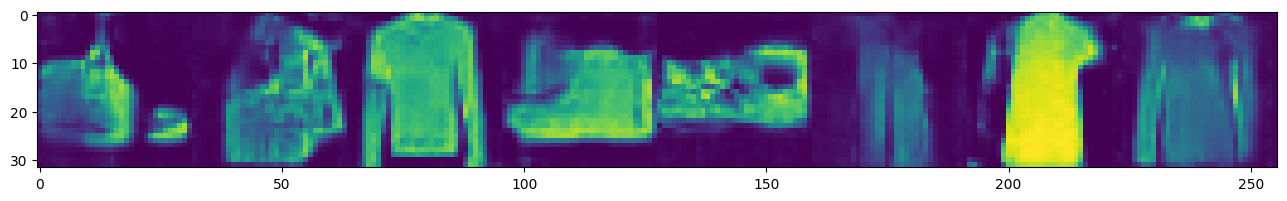

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 18/40] [D loss: 0.7013] [G loss: 2.2845]


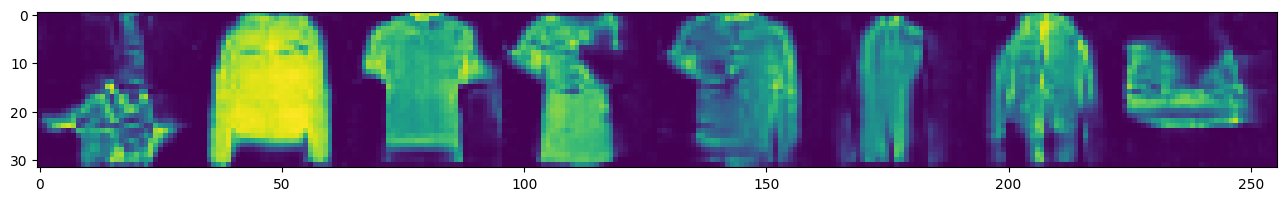

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 19/40] [D loss: 0.6993] [G loss: 2.2869]


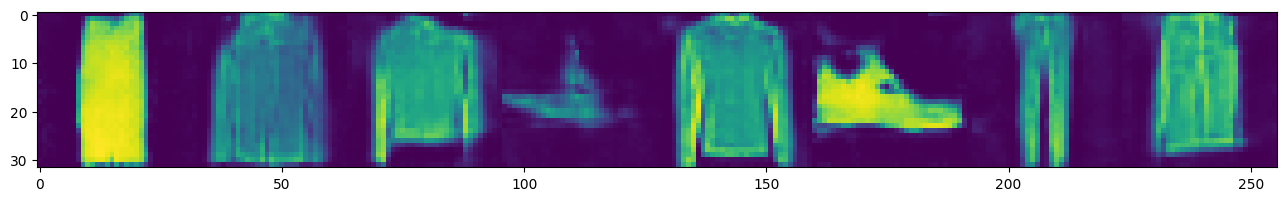

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 20/40] [D loss: 0.6968] [G loss: 2.2934]


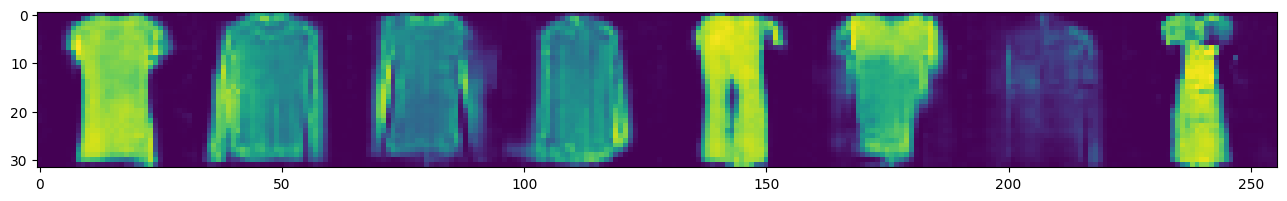

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 21/40] [D loss: 0.6943] [G loss: 2.2971]


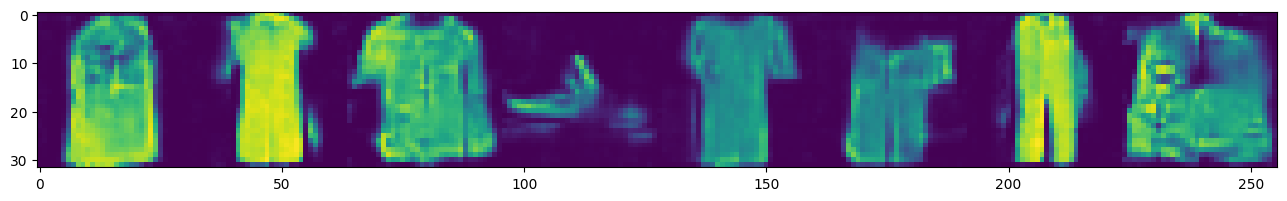

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 22/40] [D loss: 0.6939] [G loss: 2.2973]


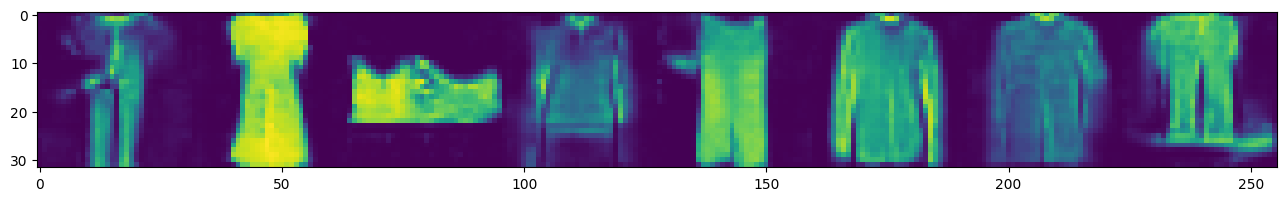

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 23/40] [D loss: 0.6935] [G loss: 2.2943]


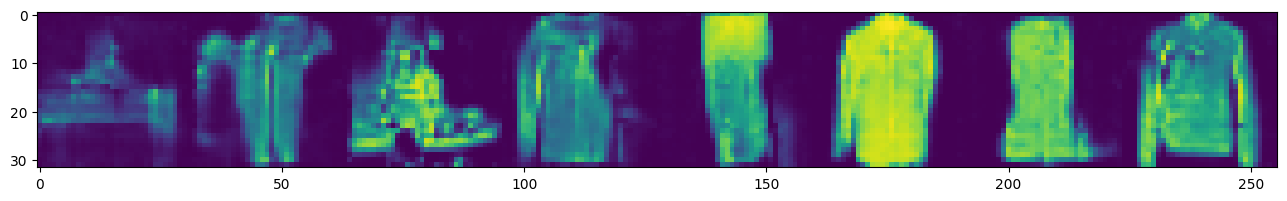

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 24/40] [D loss: 0.6924] [G loss: 2.2990]


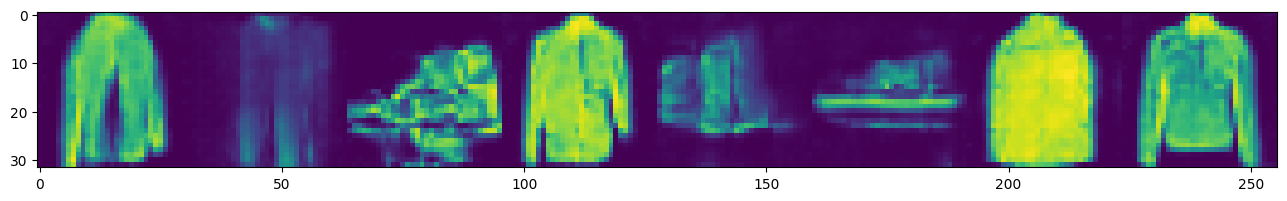

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 25/40] [D loss: 0.6929] [G loss: 2.2983]


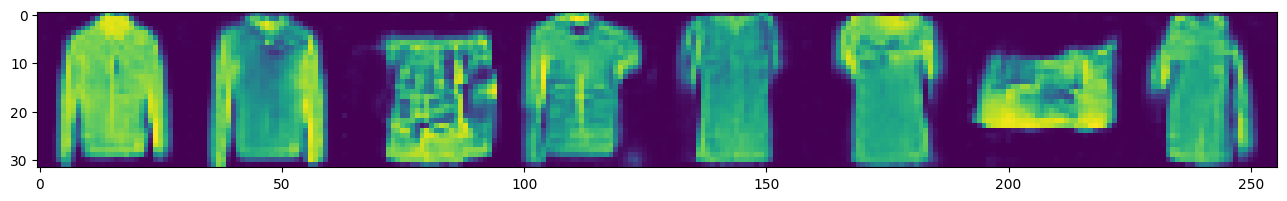

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 26/40] [D loss: 0.6917] [G loss: 2.3000]


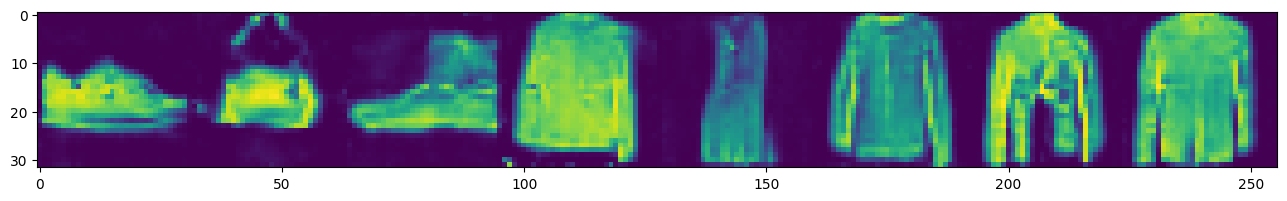

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 27/40] [D loss: 0.6912] [G loss: 2.2996]


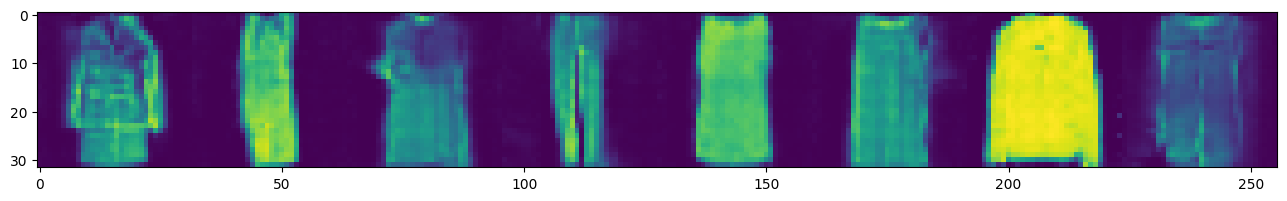

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 28/40] [D loss: 0.6914] [G loss: 2.2987]


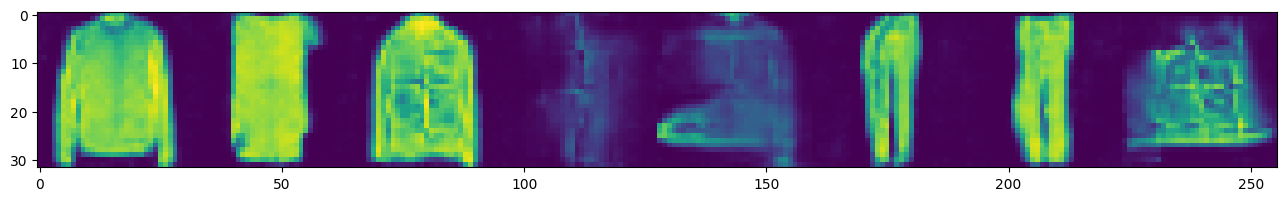

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 29/40] [D loss: 0.6905] [G loss: 2.2987]


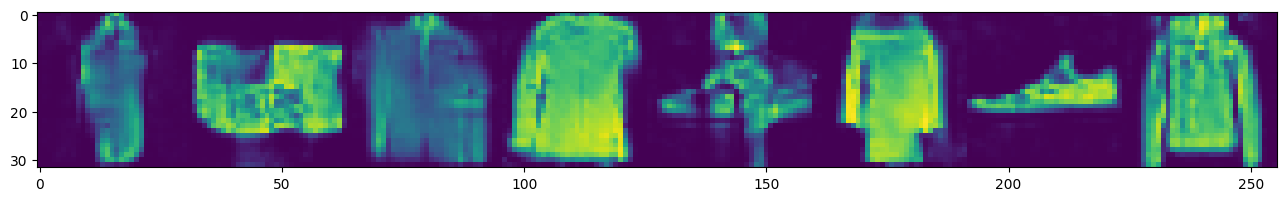

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 30/40] [D loss: 0.6895] [G loss: 2.3002]


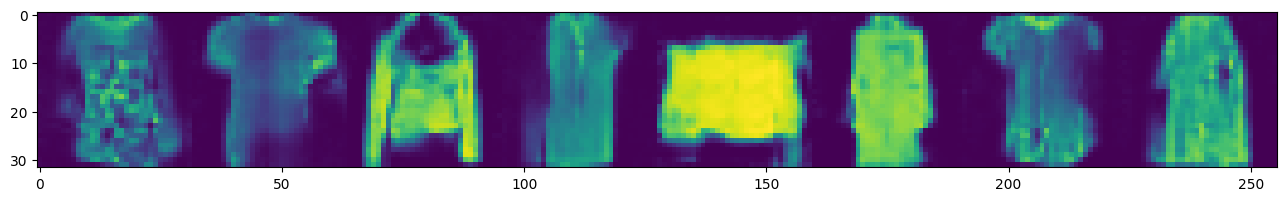

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 31/40] [D loss: 0.6884] [G loss: 2.3028]


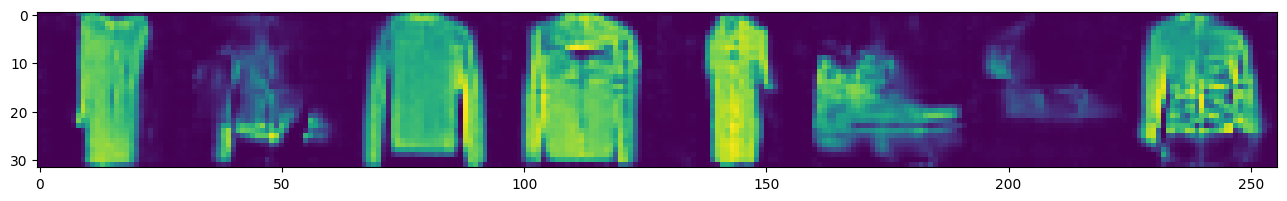

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 32/40] [D loss: 0.6892] [G loss: 2.3004]


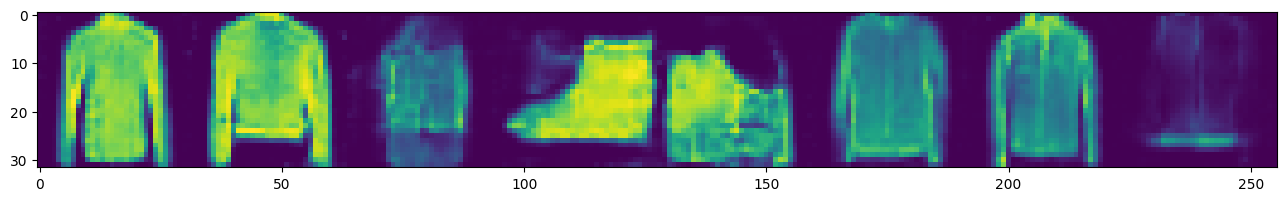

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 33/40] [D loss: 0.6879] [G loss: 2.3054]


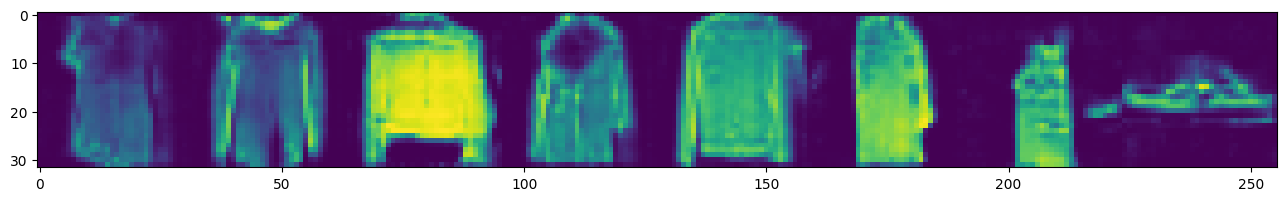

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 34/40] [D loss: 0.6883] [G loss: 2.3012]


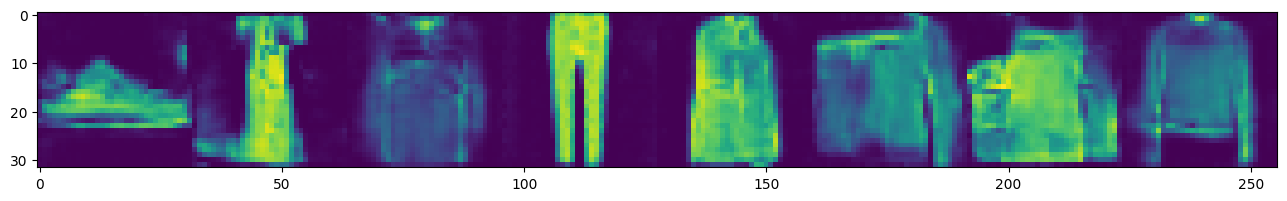

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 35/40] [D loss: 0.6890] [G loss: 2.3028]


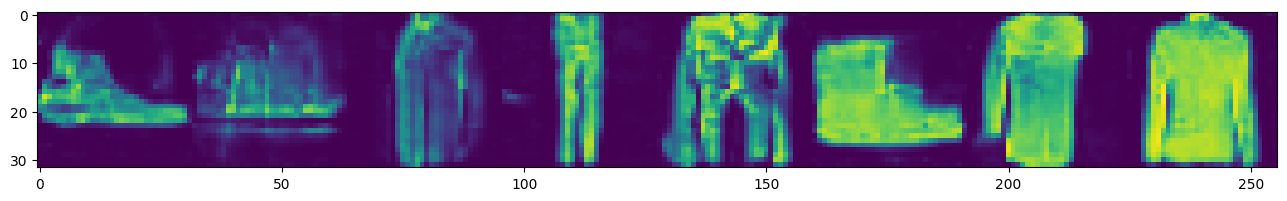

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 36/40] [D loss: 0.6879] [G loss: 2.3038]


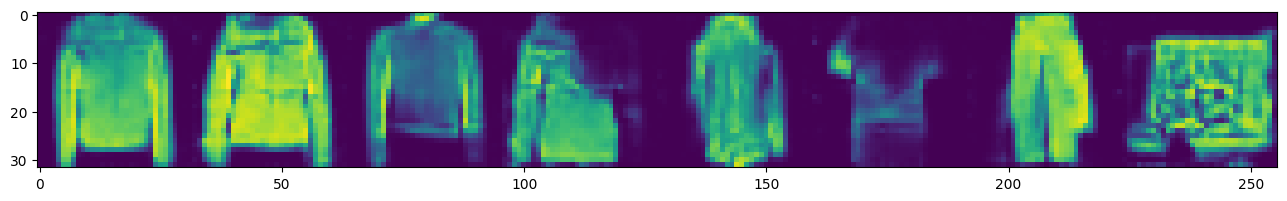

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 37/40] [D loss: 0.6887] [G loss: 2.3012]


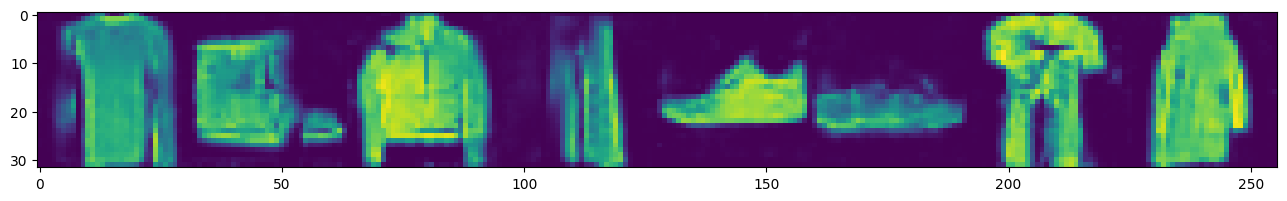

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 38/40] [D loss: 0.6879] [G loss: 2.3023]


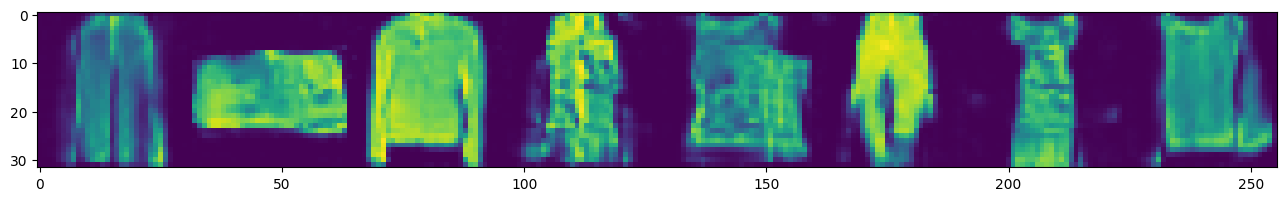

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 39/40] [D loss: 0.6873] [G loss: 2.3030]


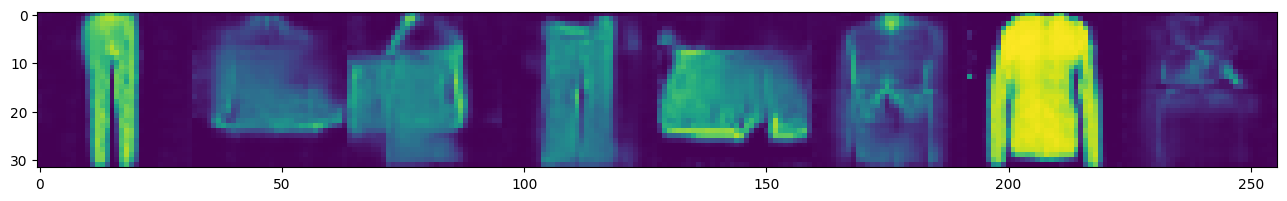

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 40/40] [D loss: 0.6877] [G loss: 2.3018]


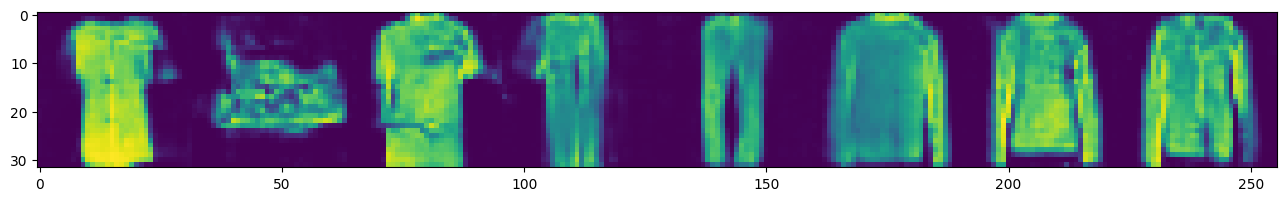

In [20]:
gan = GANManager() # You can pass your arguments to the call.
gan_history = gan.train(dataloader)

### ❓ **Question 3**
> - *(4 points)* How can we generate images from a specific class in GAN? 

اضافه کردن امبدینگ برچسب ها به کلاس جنریتور و دسکریمینیتور و اضافه کردن به بردار ورودی 
- *(Bonus - 15 points)* Implement your idea and plot 8 images from each of the 10 classes.


In [22]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Generator, self).__init__()

        ##########################################################
        # TODO (2 points): 
        # Define the generator model here. You may use linear layers, 
        # normalization layers, and activation layers.  
        ##########################################################

        self.generator = nn.Sequential(
            # in 288*1*1
            nn.ConvTranspose2d(288, 16*16, kernel_size=4, stride=1, padding=0, device=DEVICE),
            nn.BatchNorm2d(16*16, device=DEVICE),
            nn.ReLU(),  
            # in 256*4*4  
            nn.ConvTranspose2d(16*16, 16*8, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*8, device=DEVICE),
            nn.ReLU(),
            # in 128*8*8  
            nn.ConvTranspose2d(16*8, 16*4, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*4, device=DEVICE),
            nn.ReLU(),
            # in 64*16*16
            nn.ConvTranspose2d(16*4, 1, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.Tanh()
            # out 1*32*32
            )
        self.embedding = nn.Embedding(10, 32, device=DEVICE)

    def forward(self, z, y): 

        #img = None

        ##########################################################
        # TODO (2 points): 
        # Generate images from the random noise `z`.
        ##########################################################
        y = self.embedding(y).reshape(8, 32, 1, 1)
        z = torch.cat((z, y), 1)
        img = self.generator(z)

        return img

class Discriminator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Discriminator, self).__init__()
        
        ##########################################################
        # TODO (2 points): 
        # Define the Discriminator model here. You may use linear 
        # layers, normalization layers, and activation layers.  
        ##########################################################
        self.descriminator = nn.Sequential(
            # in 1*32*32
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.LeakyReLU(0.2),
            # in 16*16*16
            nn.Conv2d(16, 16*2, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*2, device=DEVICE),
            nn.LeakyReLU(0,2),
            # in 32*8*8
            nn.Conv2d(16*2, 16*4, kernel_size=4, stride=2, padding=1, device=DEVICE),
            nn.BatchNorm2d(16*4, device=DEVICE),
            nn.LeakyReLU(0,2),
            # in 64*4*4
            nn.Conv2d(16*4, 1, kernel_size=4, stride=2, padding=0, device=DEVICE),
            nn.Sigmoid()
            # out 1*1
            )
        self.embedding = nn.Embedding(10, 32, device=DEVICE)
        self.linear = nn.Linear(1056, 1024, device=DEVICE)
        self.relu = nn.ReLU()
    
    def forward(self, img, y):

        ##########################################################
        # TODO (2 points): 
        # Predict whether each image in `img` is real or fake.
        ##########################################################
        y = self.embedding(y)
        y = y.reshape(8, 1, 1, 32)
        img = torch.cat((img, y), 2).reshape(8, -1)
        img = self.linear(img)
        img = self.relu(img)
        img = img.reshape(8,1,32,32)

        real_or_fake = self.descriminator(img)

        return real_or_fake

class GANManager():
    def __init__(self, *args, **kwargs):
        
        ##########################################################
        # TODO (3 points): 
        # 1) Instantiate the Generator and the Discriminator.
        # 2) Define your optimizer(s). You can use Adam.
        ##########################################################

        self.generator = Generator()
        self.discriminator = Discriminator()
        self.opt_d = optim.Adam(self.discriminator.parameters(), lr=LR)
        self.opt_g = optim.Adam(self.generator.parameters(), lr=LR)

    def train(self, dataloader, **kwargs):

        history = dict(g_loss=[], d_loss=[])
        for epoch in range(EPOCHS):
            total_g_loss = []
            total_d_loss = []
            for i, (batch_x, _) in enumerate(tqdm(dataloader)):
                batch_x = batch_x.to(DEVICE)
                batch_y = _.to(DEVICE)
                #batch_y = F.one_hot(batch_y, num_classes=10)
                #print(batch_y)
                ##########################################################
                # TODO (15 points): 
                # Calculate the loss for the Generator and the Discriminator.
                # Perform the optimization on `batch_x`.
                ##########################################################
                self.opt_d.zero_grad()
                labels = (torch.ones(8)*0.9).to(DEVICE)
                out = self.discriminator(batch_x, batch_y).reshape(-1) 
                loss_d_real = nn.BCELoss()(out, labels)
                noise = torch.randn(8, 256, 1, 1).to(DEVICE)
                fake_imgs = self.generator(noise, batch_y)
                labels = (torch.ones(8)*0.1).to(DEVICE)
                out = self.discriminator(fake_imgs.detach(), batch_y).reshape(-1)
                loss_d_fake = nn.BCELoss()(out, labels)

                discriminator_loss = loss_d_real + loss_d_fake
                discriminator_loss.backward()
                self.opt_d.step()

                

                self.opt_g.zero_grad()
                labels = torch.ones(8).to(DEVICE)
                out = self.discriminator(fake_imgs, batch_y).reshape(-1)
                generator_loss = nn.BCELoss()(out, labels)
                generator_loss.backward()
                self.opt_g.step()

                #generator_loss = None
                #discriminator_loss = None
                
                total_g_loss.append(generator_loss.item())
                total_d_loss.append(discriminator_loss.item())


            mean_d_loss = np.mean(total_d_loss)
            mean_g_loss = np.mean(total_g_loss)

            print(
                "[Epoch: %d/%d] [D loss: %.4f] [G loss: %.4f]"
                % (epoch+1, EPOCHS, mean_d_loss, mean_g_loss)
            )
            l = epoch %10
            y = batch_y * 0 + l
            self.sample(8, y, plot=True)

            history['d_loss'].append(mean_d_loss)
            history['g_loss'].append(mean_g_loss)

        return history

    def sample(self, n, y, plot=True):

        ##########################################################
        # TODO (1 points): 
        # First, assign proper Gaussian noises to `z`.
        # Then, use can see that by using the Generator, we can
        # make new images and plot them.
        ##########################################################

        z = torch.randn(n, 256, 1, 1).to(DEVICE)
        #y = torch.ones(8).to(DEVICE)
        with torch.no_grad():
            gen_imgs = self.generator(z, y).to('cpu')
            if plot:
                plot_images(gen_imgs)
            return gen_imgs

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 1/40] [D loss: 0.6855] [G loss: 2.3429]


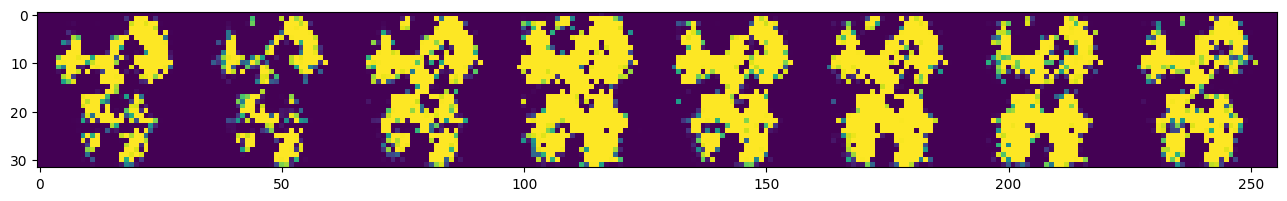

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 2/40] [D loss: 0.7745] [G loss: 2.1586]


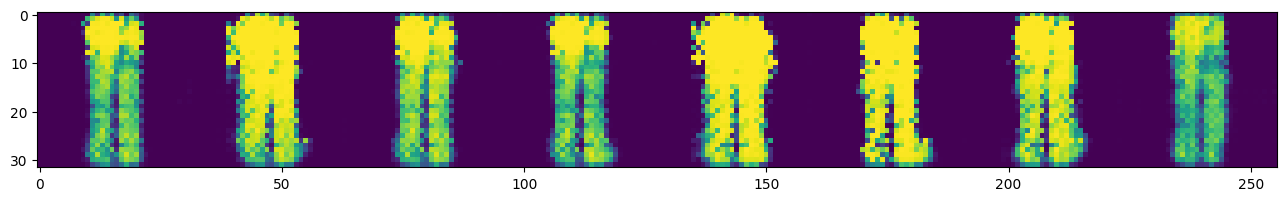

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 3/40] [D loss: 0.9262] [G loss: 1.7756]


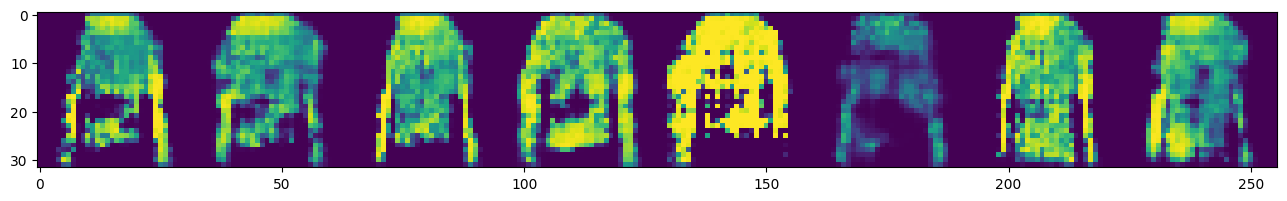

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 4/40] [D loss: 1.0130] [G loss: 1.5004]


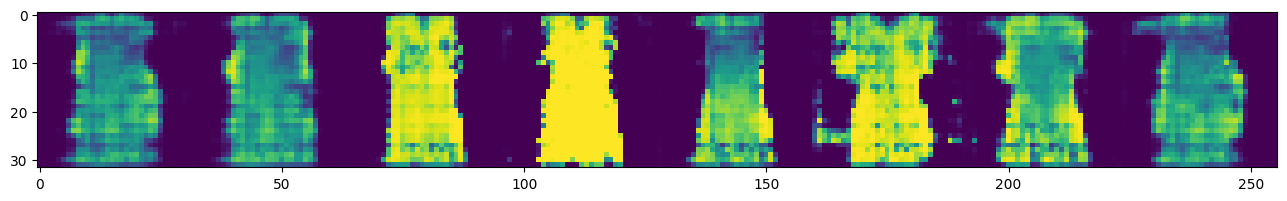

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 5/40] [D loss: 1.0641] [G loss: 1.3797]


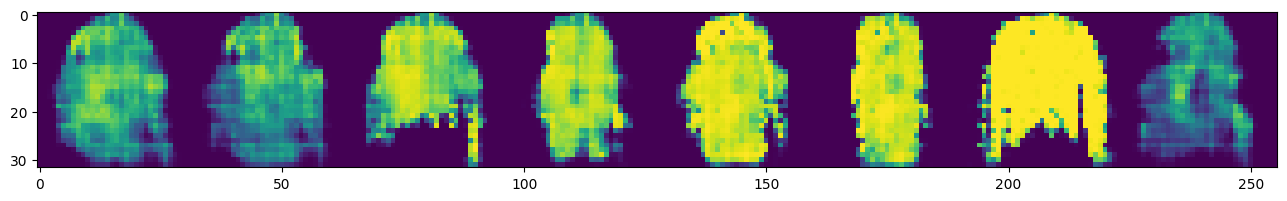

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 6/40] [D loss: 1.0981] [G loss: 1.2834]


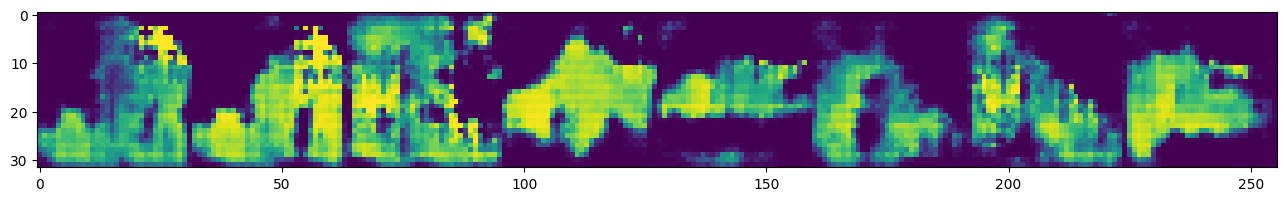

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 7/40] [D loss: 1.1013] [G loss: 1.3152]


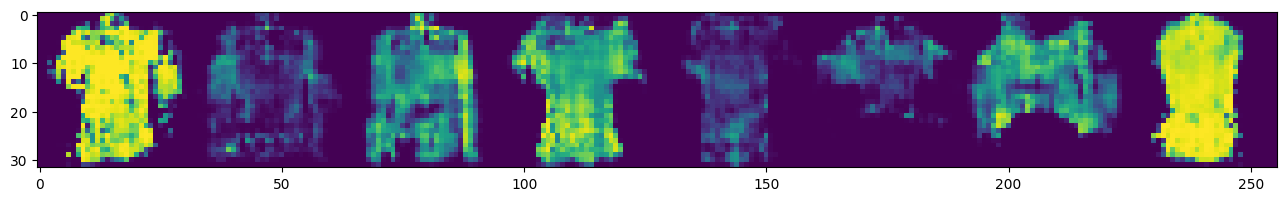

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 8/40] [D loss: 1.0998] [G loss: 1.3296]


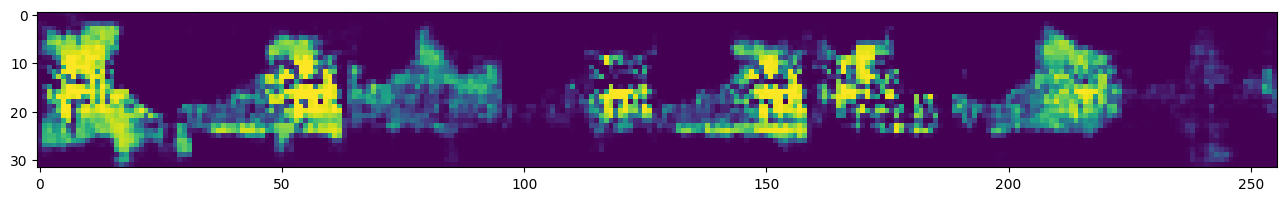

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 9/40] [D loss: 1.0864] [G loss: 1.3763]


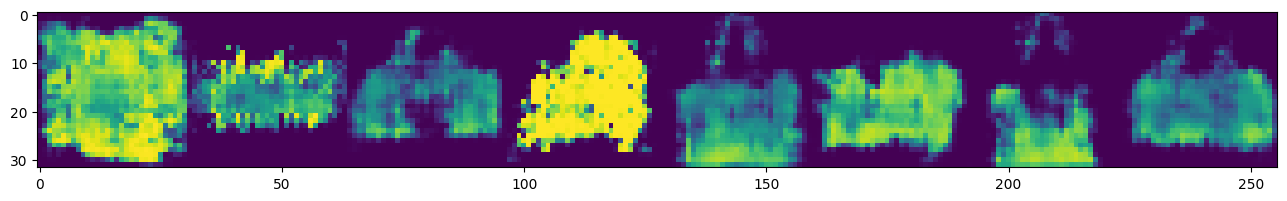

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 10/40] [D loss: 1.0742] [G loss: 1.4034]


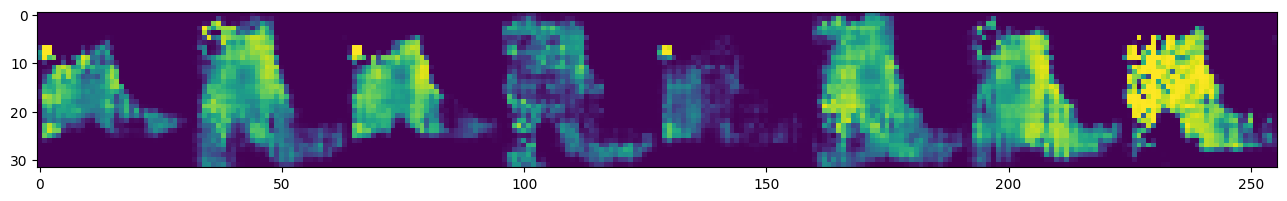

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 11/40] [D loss: 1.0781] [G loss: 1.4035]


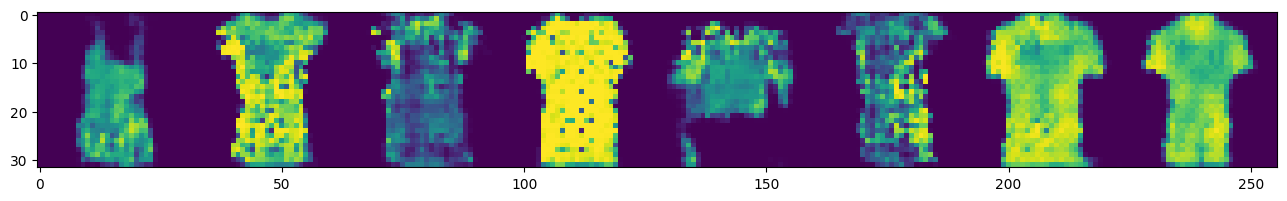

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 12/40] [D loss: 1.0758] [G loss: 1.4127]


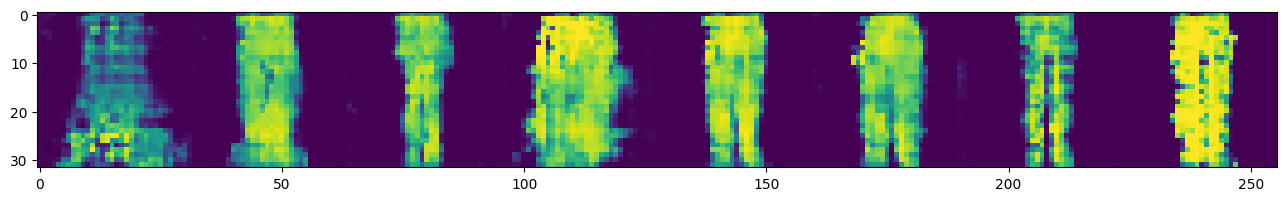

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 13/40] [D loss: 1.0893] [G loss: 1.3826]


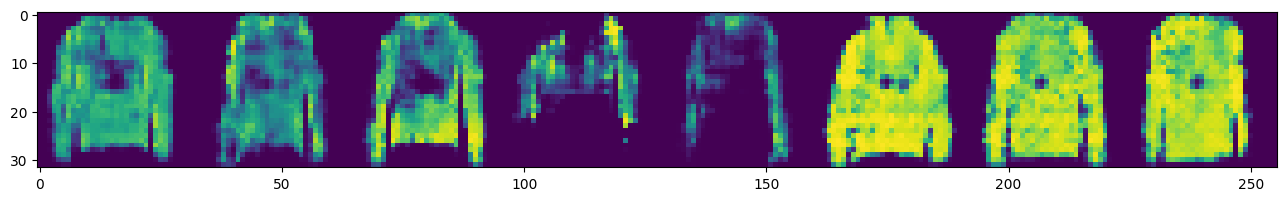

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 14/40] [D loss: 1.1093] [G loss: 1.3332]


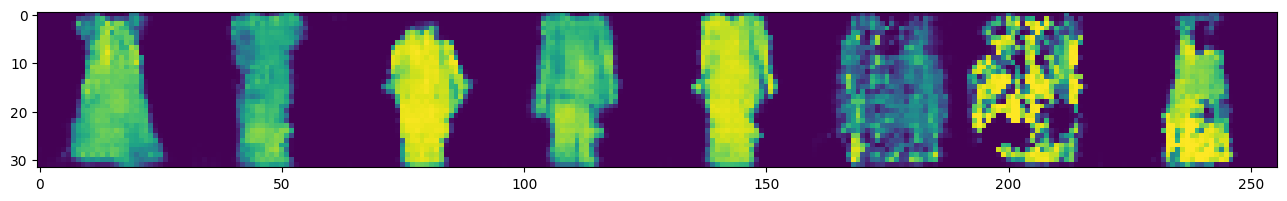

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 15/40] [D loss: 1.0969] [G loss: 1.3594]


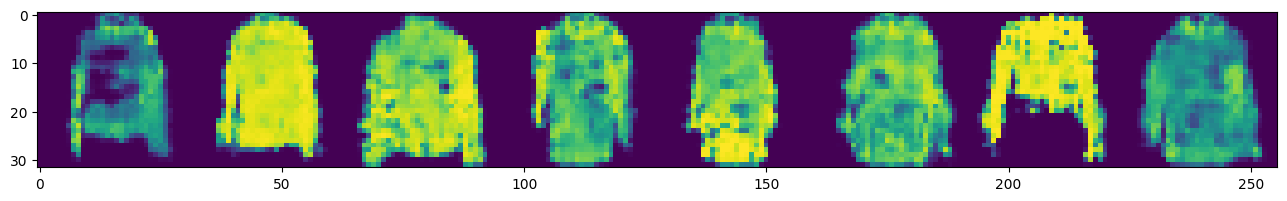

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 16/40] [D loss: 1.0994] [G loss: 1.3545]


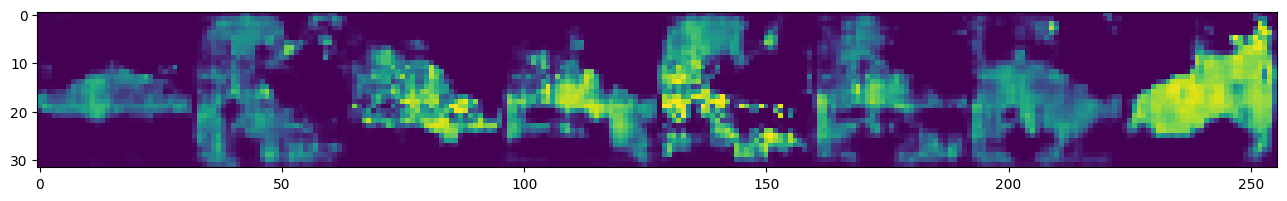

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 17/40] [D loss: 1.0973] [G loss: 1.3610]


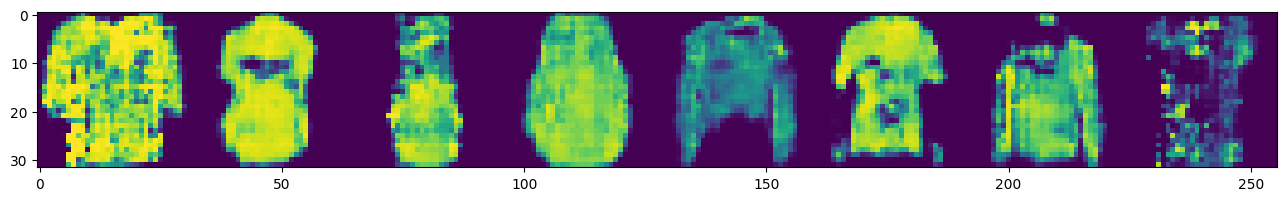

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 18/40] [D loss: 1.1081] [G loss: 1.3308]


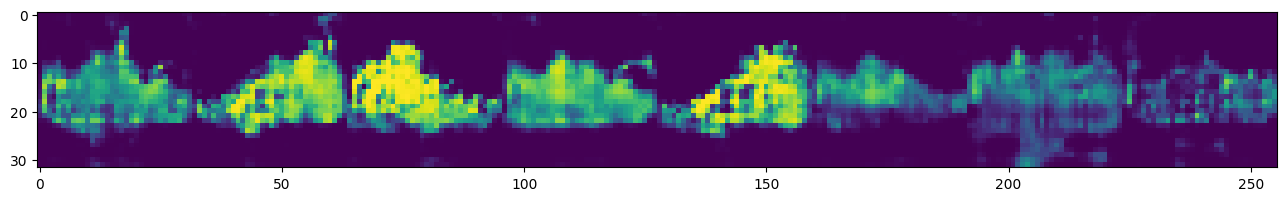

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 19/40] [D loss: 1.1094] [G loss: 1.3308]


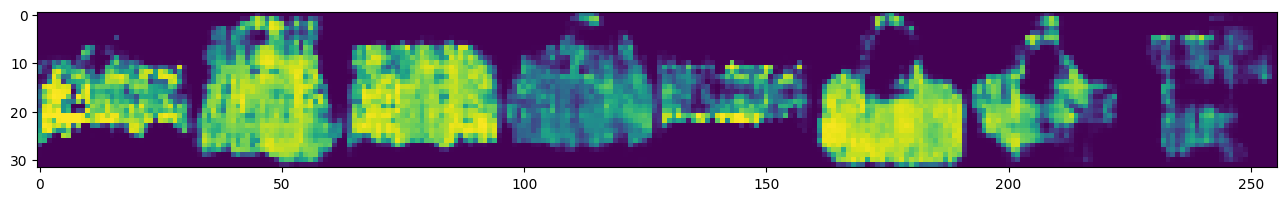

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 20/40] [D loss: 1.1101] [G loss: 1.3220]


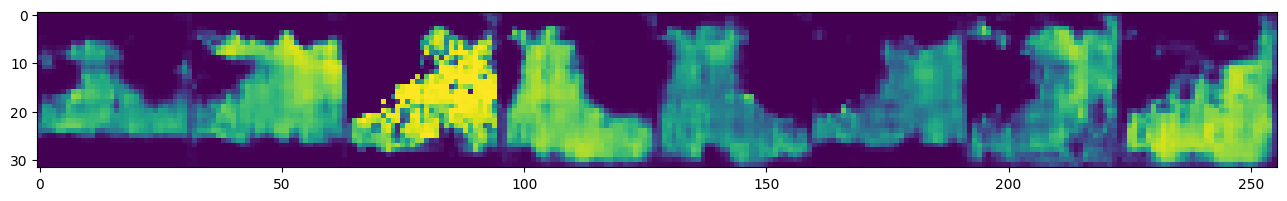

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 21/40] [D loss: 1.1104] [G loss: 1.3192]


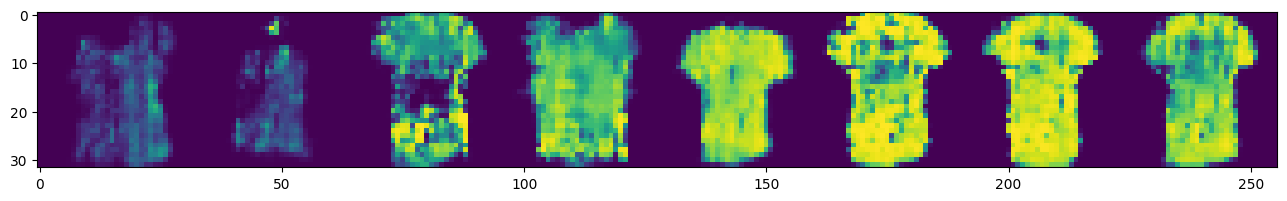

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 22/40] [D loss: 1.0966] [G loss: 1.3536]


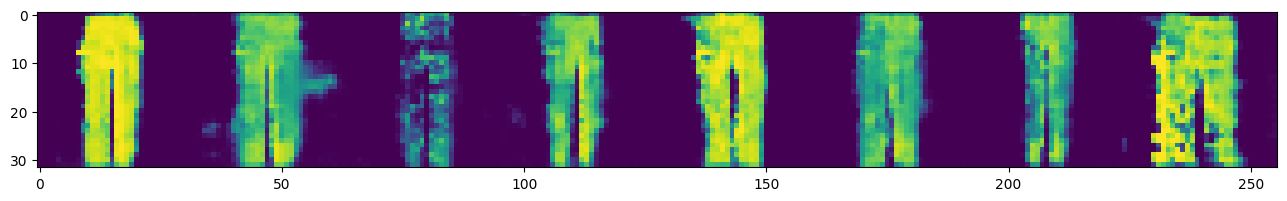

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 23/40] [D loss: 1.1029] [G loss: 1.3390]


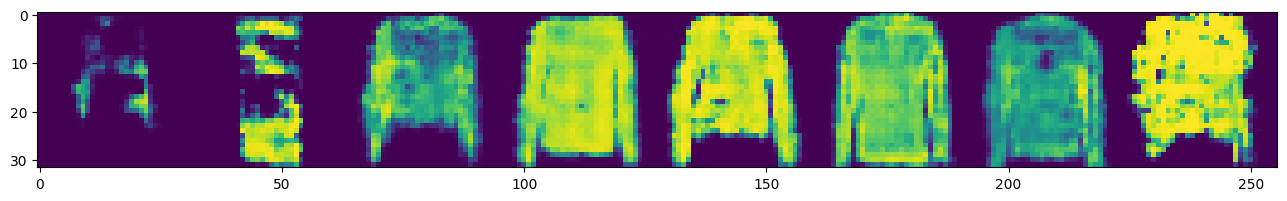

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 24/40] [D loss: 1.1140] [G loss: 1.3143]


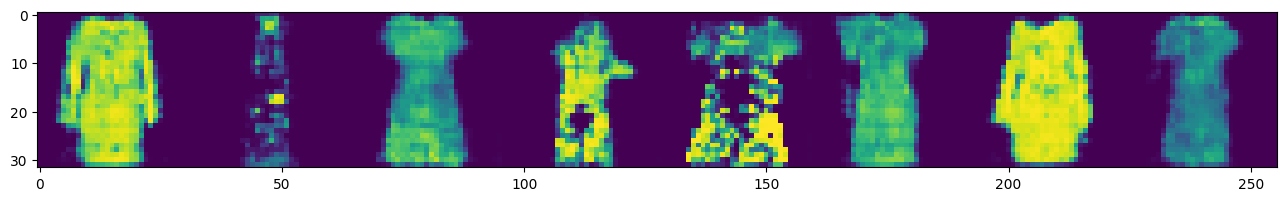

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 25/40] [D loss: 1.1083] [G loss: 1.3208]


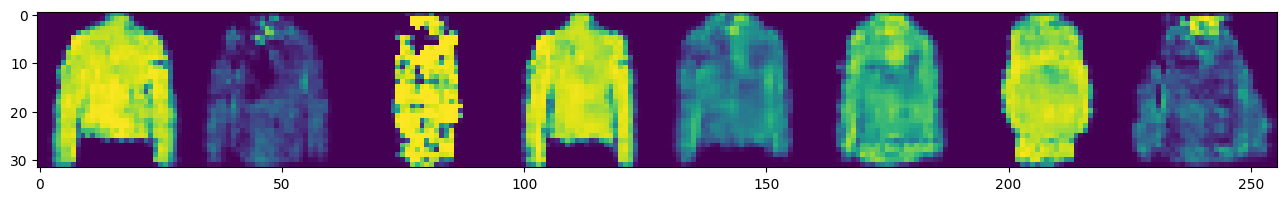

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 26/40] [D loss: 1.1136] [G loss: 1.3155]


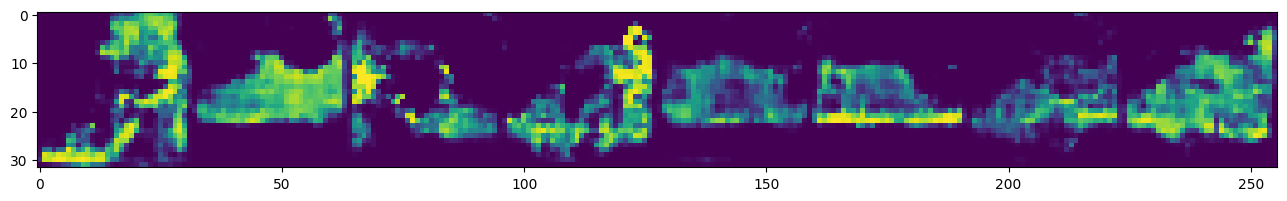

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 27/40] [D loss: 1.1054] [G loss: 1.3382]


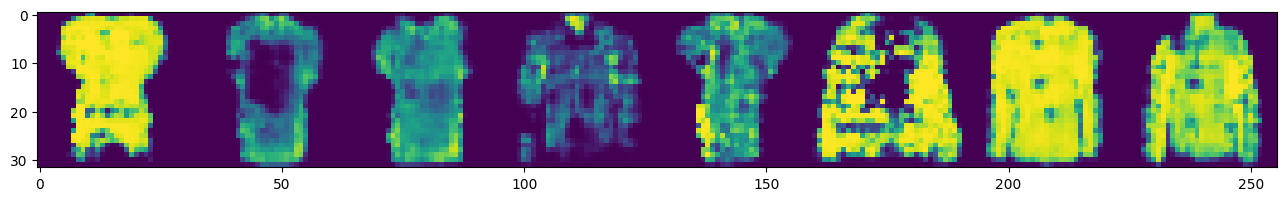

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 28/40] [D loss: 1.1096] [G loss: 1.3274]


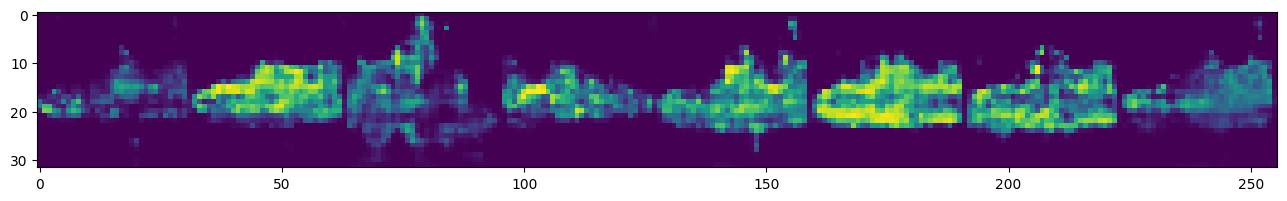

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 29/40] [D loss: 1.1049] [G loss: 1.3366]


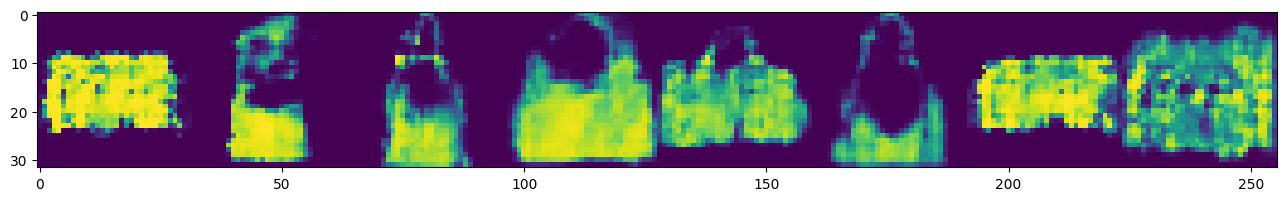

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 30/40] [D loss: 1.0935] [G loss: 1.3616]


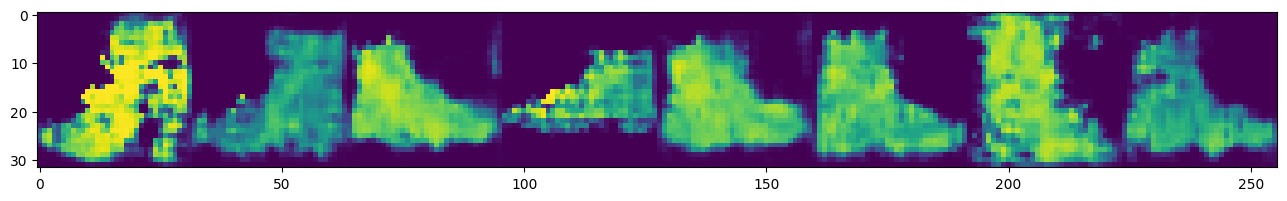

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 31/40] [D loss: 1.1069] [G loss: 1.3380]


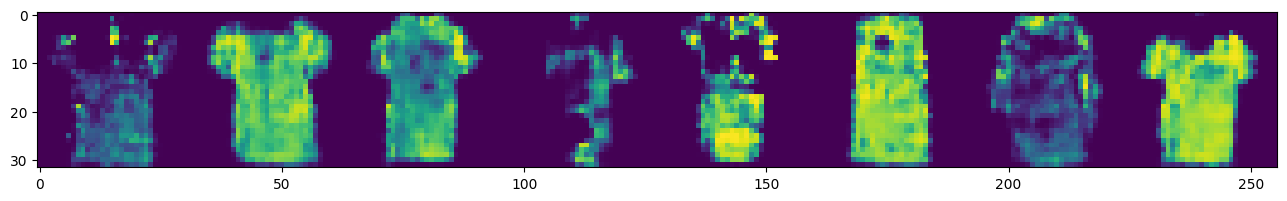

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 32/40] [D loss: 1.1019] [G loss: 1.3360]


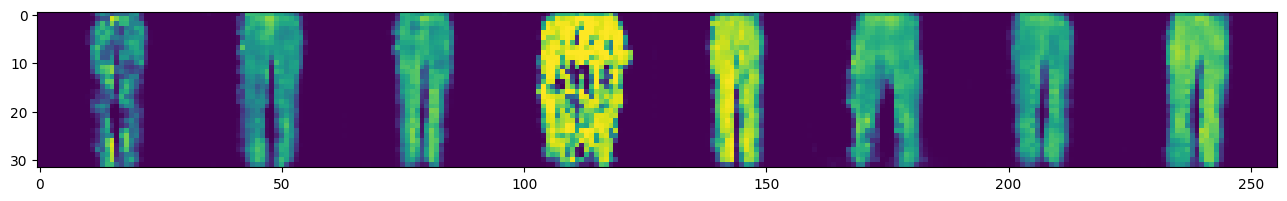

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 33/40] [D loss: 1.1058] [G loss: 1.3352]


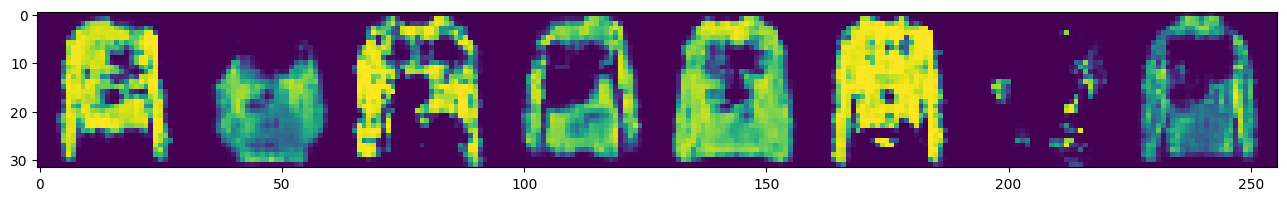

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 34/40] [D loss: 1.0905] [G loss: 1.3720]


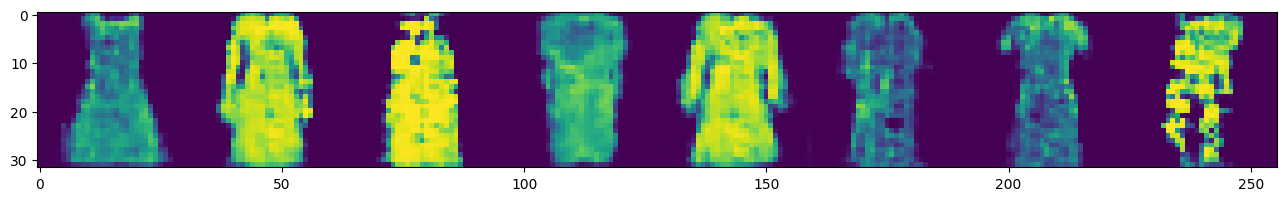

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 35/40] [D loss: 1.0851] [G loss: 1.3885]


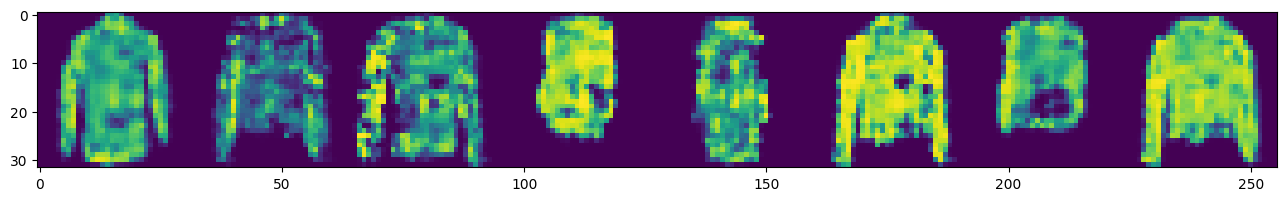

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 36/40] [D loss: 1.0885] [G loss: 1.3706]


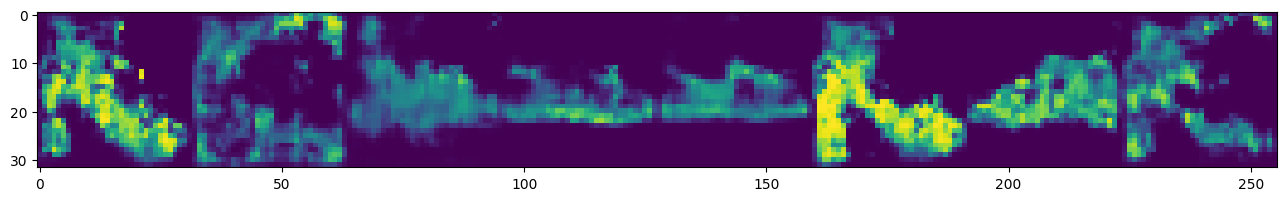

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 37/40] [D loss: 1.0861] [G loss: 1.3792]


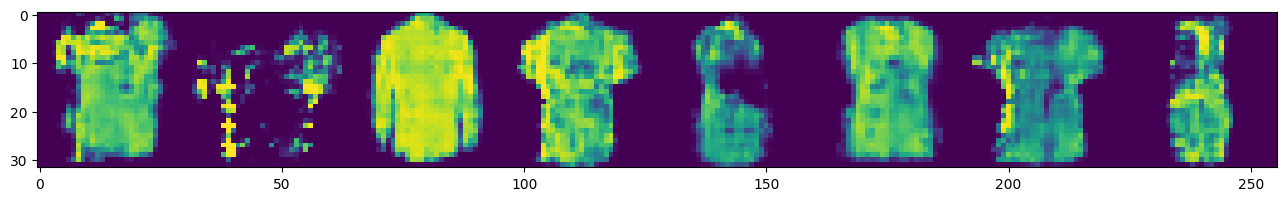

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 38/40] [D loss: 1.0821] [G loss: 1.3918]


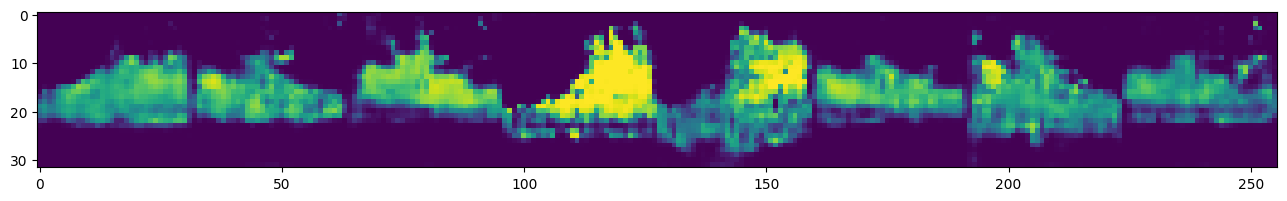

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 39/40] [D loss: 1.0805] [G loss: 1.4000]


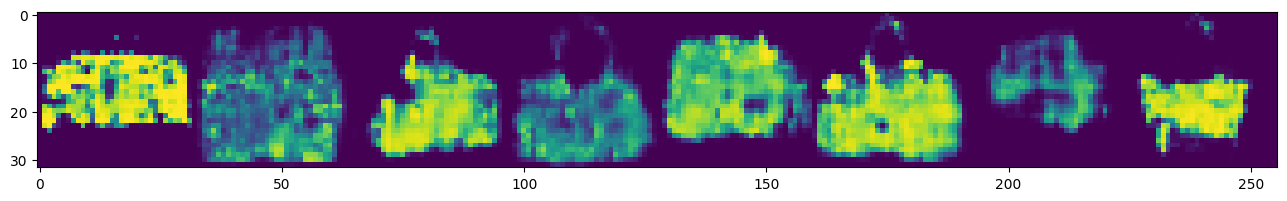

  0%|          | 0/7500 [00:00<?, ?it/s]

[Epoch: 40/40] [D loss: 1.0760] [G loss: 1.3951]


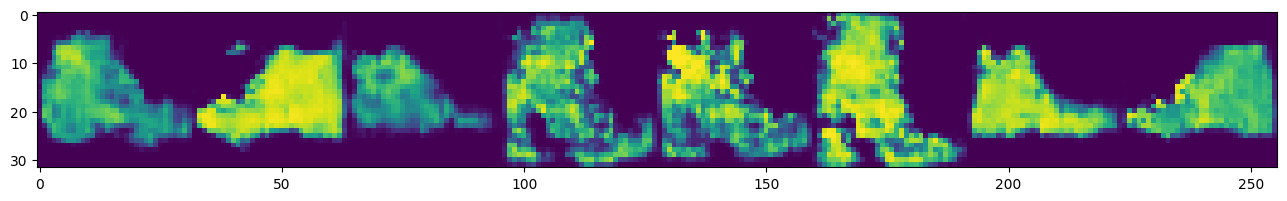

In [23]:
EPOCHS= 40
cgan = GANManager() # You can pass your arguments to the call.
cgan_history = cgan.train(dataloader)

## Comparisons (10 points)

History of each training has been stored in `[MODEL]_history`. Plot the losses for each model. Also sample images from each model and compare your results. 

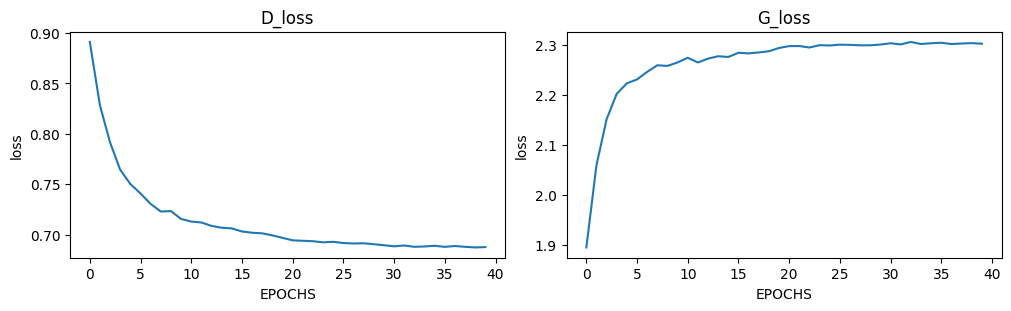

In [21]:
fix, ax = plt.subplots(1, 2, figsize=(10, 3), layout='constrained')
ax[0].set_title('D_loss')
ax[0].set_xlabel('EPOCHS')
ax[0].set_ylabel('loss')
ax[0].plot(gan_history['d_loss'])
ax[1].set_title('G_loss')
ax[1].set_xlabel('EPOCHS')
ax[1].set_ylabel('loss')
ax[1].plot(gan_history['g_loss'])

#Conditional_GAN 

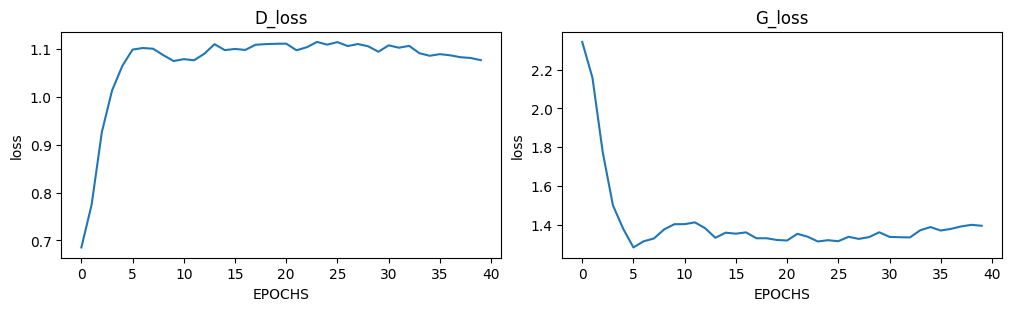

In [24]:
fix, ax = plt.subplots(1, 2, figsize=(10, 3), layout='constrained')
ax[0].set_title('D_loss')
ax[0].set_xlabel('EPOCHS')
ax[0].set_ylabel('loss')
ax[0].plot(cgan_history['d_loss'])
ax[1].set_title('G_loss')
ax[1].set_xlabel('EPOCHS')
ax[1].set_ylabel('loss')
ax[1].plot(cgan_history['g_loss'])